In [1]:
import pandas

In [2]:
def get_condition(row):
    
    even = not (row.subject_id % 2)
    
    if row.subject_id == 0:
        even = False
    
    if np.isnan(row['syncvalue[SubTrial]']):
        return np.nan
    
#     print row
    
    if even:
        return {11:'cs-', 12:'cs+', 14:'cs+', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    else:
        return {11:'cs+', 12:'cs-', 13:'cs+', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    

In [3]:
df = pandas.read_excel('/home/gdholla1/data/daphne/behavior/Task2_All Participants.xlsx')
df.ix[df.Subject == 'P05', 'subject'] = 0

df['onset'] = df['face3sec.OnsetTime'] - df['Waitforscanner1c.RTTime']
df['onset'] /= 1000

# df['condition'] = df['syncvalue[SubTrial]']

# df['condition'] = df['condition'].map({11:'cs+', 12:'cs-', 13:'shock'})

df.ix[df.Subject == 'P05', 'Subject'] = 0

df['subject_id'] = df.Subject.astype(int)

df['condition'] = df.apply(get_condition, 1)

In [4]:
df.to_pickle('/home/gdholla1/data/daphne/behavior/all_data2.pandas')

In [5]:
import pyfir

In [6]:
def get_signal(subject_id, mask, mask_type='disjunct', interpolation='nearestneighbour', phys_filtered=False):

    if mask == 'LC_both':
        signal1 = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_LC_L/_interp_trilinear/_extract_weighted_phys1/run2_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id))        
        signal2 = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_LC_R/_interp_trilinear/_extract_weighted_phys1/run2_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id))        
        
        signal = signal1 + signal2
    else:    
        signal = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_%2s/_interp_trilinear/_extract_weighted_phys1/run2_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id, mask))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

In [7]:
def get_onsets(subject_id):
    df = pandas.read_pickle('/home/gdholla1/data/daphne/behavior/all_data2.pandas')
    
    df = df[df.Subject == subject_id]
    
    onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
              'cs-':df[df.condition == 'cs-'].onset.tolist(),
              'shock':df[df.condition == 'shock'].onset.tolist()}
    
    return onsets
    
    
    

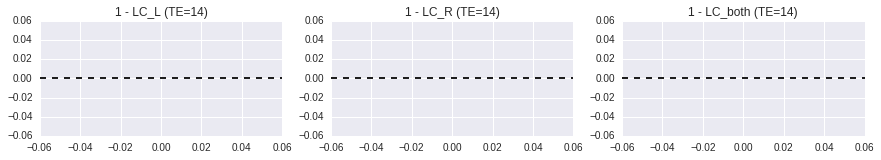

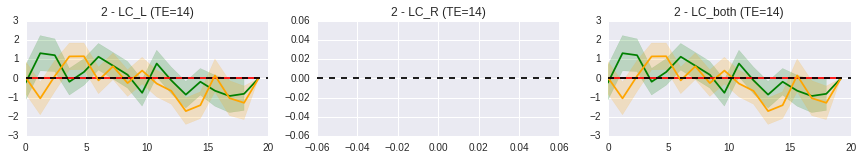

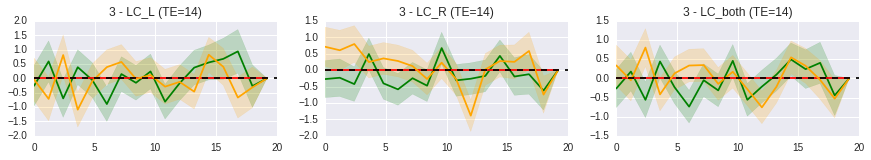

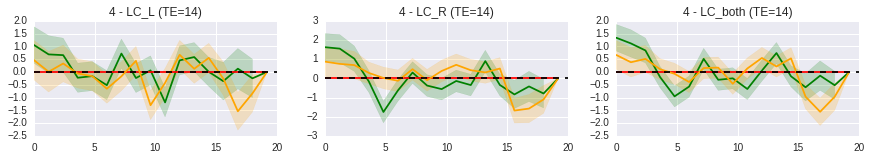

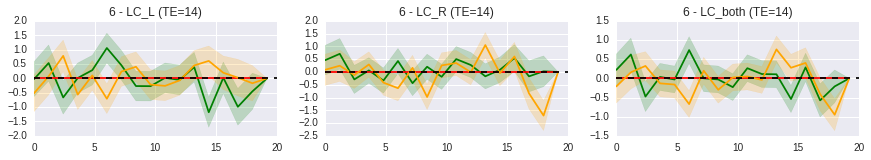

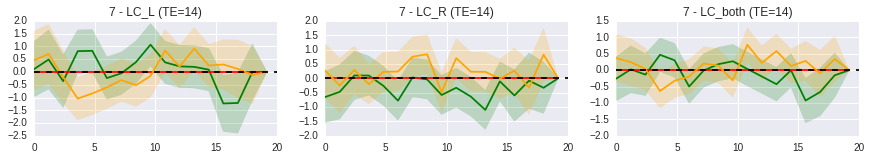

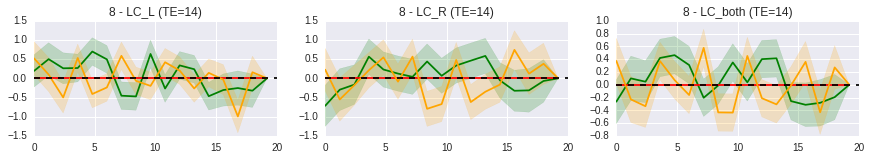

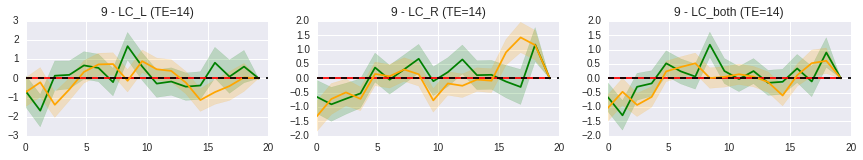

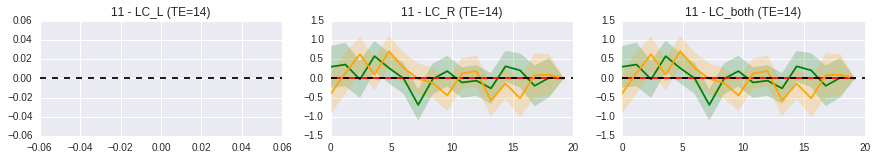

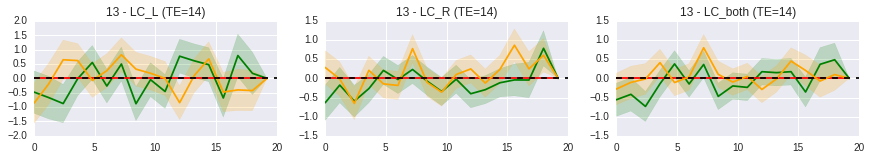

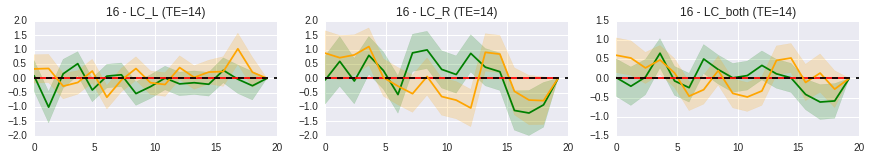

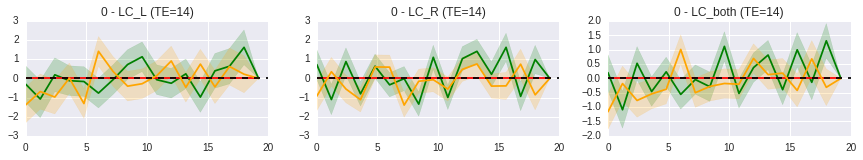

In [8]:
firs = []

for subject_id in df.subject_id.unique():
    plt.figure(figsize=(20, 7))
    for i, mask in enumerate(['LC_L', 'LC_R', 'LC_both']):
        
        try:
            signal = get_signal(subject_id, mask, interpolation='weighted', mask_type='disjunct', phys_filtered=False)
            onsets = get_onsets(subject_id)


            if onsets:
                fir = pyfir.FIR(signal)
                r = fir.fit(onsets, 1.2, resolution = 1.2, len_impulse=20)

                plt.subplot(3, 4, i+1)
                plt.title('%s - %s (TE=14)' % (subject_id, mask))
                r.plot_results({'shock':'red',
                                'cs+':'orange',
                                'cs-':'green',})
                #plt.ylim(-1, 1)

                if i != 7:
                    plt.gca().legend_.remove()

                for condition, hrf in zip(r.conditions, r.beta):
                    for time, value in zip(r.times, hrf):
                        firs.append({'mask':mask,
                                     'subject_id':subject_id,
                                     'condition':condition,
                                     't':time,
                                     'value':value})


        except Exception as e:
            print 'Error with %s/%s - %s' % (subject_id, mask, e)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


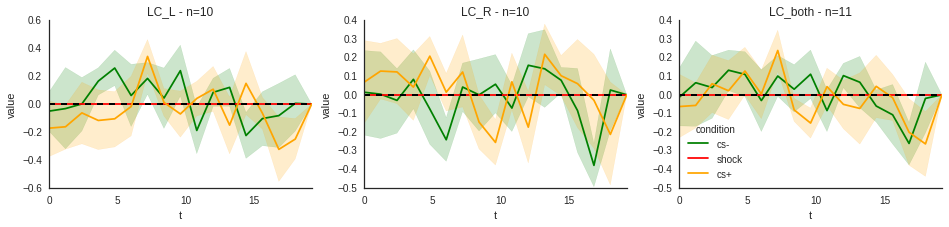

In [9]:
df_firs = pandas.DataFrame(firs)
df_firs = df_firs[~df_firs.value.isnull()]
sns.set_palette(['green', 'red','orange', ])
plt.figure(figsize=(16, 3))

sns.set_style('white')


# for i, ((te, mask), d) in enumerate(df_firs.groupby(['TE', 'mask'], sort=False)):

# yticks = np.arange(-0.3, 0.51, .1).round(1)

for i, mask in enumerate(['LC_L', 'LC_R', 'LC_both']):
    plt.subplot(1, 3, i+1)
#     plt.ylim(-.3, .5)
    sns.tsplot(df_firs[(df_firs['mask'] == mask)], unit='subject_id', time='t', value='value', condition='condition', ci=67)
    
    if i != 2:
        plt.gca().legend_.remove()
        
    plt.title('%s - n=%d' % (mask, df_firs[(df_firs['mask'] == mask)].subject_id.unique().shape[0]))
    plt.axhline(0, lw=2, ls='--', c='k')
    
#     if i < 5:
#         plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))
#         plt.xlabel('')
#     else:
#         plt.xlabel('t (s)')
        
#     if i % 5 == 0:
#         plt.ylabel('% signal change')
        
#         plt.yticks(yticks, yticks)
#     else:
#         plt.yticks(yticks, [''] * len(yticks))
#         plt.ylabel('')
    
# plt.suptitle('Mean signal over all %s subjects' % df_firs.subject_id.unique().shape, fontsize=24)

sns.despine()
plt.savefig('all_nuclei.pdf', transparent=True)

In [10]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

sns.set_palette('deep')

level2_dict = []
adj_r = []

pars = ['cs+', 'cs-']

for subject_id in df.subject_id.unique():


    onsets_dict = get_onsets(subject_id)
    
    if onsets_dict:
        conditions = []
        onsets = []
        for key in onsets_dict.keys():
            conditions += [key] * len(onsets_dict[key])
            onsets += onsets_dict[key]

        paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                        onset=onsets,
                                                        duration=[[3.]] * len(conditions))
        try:
            signal = get_signal(subject_id, 'LC_L')
            tr = 1.2
            frametimes = np.arange(0, signal.shape[-1] * tr, tr)
            print frametimes.shape
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)
        
        except Exception as e:
            pass

        for i, (mask, d) in enumerate(df_firs.groupby(['mask'])):
            
            try:
                signal = get_signal(subject_id, mask)
                print subject_id, mask, signal.shape, X.shape
                r = sm.GLSAR(signal, X).iterative_fit()


                
                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask})
            except Exception as e:
                print e
                print 'Problem withs %s %s' % (subject_id, mask)
                
            
        plt.suptitle(subject_id, fontsize=24)

(416,)
1 LC_L (416,) (416, 8)
SVD did not converge
Problem withs 1 LC_L
1 LC_R (416,) (416, 8)
SVD did not converge
Problem withs 1 LC_R
1 LC_both (416,) (416, 8)
SVD did not converge
Problem withs 1 LC_both
(413,)
2 LC_L (413,) (413, 8)
2 LC_R (413,) (413, 8)
SVD did not converge
Problem withs 2 LC_R
2 LC_both (413,) (413, 8)


/usr/local/lib/python2.7/dist-packages/nipy/modalities/fmri/design_matrix.py:191: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if rmatrix == None:


(414,)
3 LC_L (414,) (414, 8)
3 LC_R (414,) (414, 8)
3 LC_both (414,) (414, 8)
(412,)
4 LC_L (412,) (412, 8)
4 LC_R (412,) (412, 8)
4 LC_both (412,) (412, 8)
(414,)
6 LC_L (414,) (414, 8)
6 LC_R (414,) (414, 8)
6 LC_both (414,) (414, 8)
(416,)
7 LC_L (416,) (416, 8)
7 LC_R (416,) (416, 8)
7 LC_both (416,) (416, 8)
(414,)
8 LC_L (414,) (414, 8)
8 LC_R (414,) (414, 8)
8 LC_both (414,) (414, 8)
(495,)
9 LC_L (495,) (495, 8)
9 LC_R (495,) (495, 8)
9 LC_both (495,) (495, 8)
(412,)
11 LC_L (412,) (412, 8)
SVD did not converge
Problem withs 11 LC_L
11 LC_R (412,) (412, 8)
11 LC_both (412,) (412, 8)
(414,)
13 LC_L (414,) (414, 8)
13 LC_R (414,) (414, 8)
13 LC_both (414,) (414, 8)
(414,)
16 LC_L (414,) (414, 8)
16 LC_R (414,) (414, 8)
16 LC_both (414,) (414, 8)
(410,)
0 LC_L (410,) (410, 8)
0 LC_R (410,) (410, 8)
0 LC_both (410,) (410, 8)


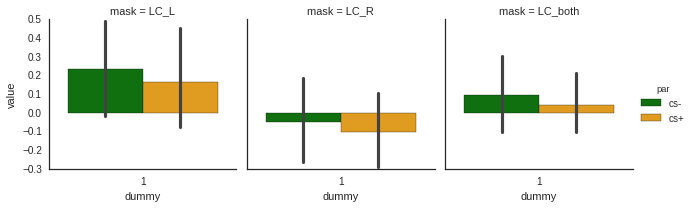

In [11]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1
#sns.set_palette('husl', 4)
f = sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', size=3,
              palette=['green', 'orange', 'red'],
                   col_order=['LC_L', 'LC_R', 'LC_both'],
              hue_order=['cs-', 'cs+' ],
            kind='bar',
                  ci=95)

In [12]:
%load_ext rpy2.ipython

In [17]:
tmp = []

for (mask, condition), d in df_glm.groupby(['mask', 'par']):
    values = d.value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':condition, 'BF':bf[0]})

LC_L cs+
LC_L cs-
LC_R cs+
LC_R cs-
LC_both cs+
LC_both cs-


In [18]:
np.round(pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'].ix[:, ['cs-', 'cs+']], 2)

,cs-,cs+
mask,,
LC_L,1.56,0.83
LC_R,0.24,0.18
LC_both,0.65,0.44


In [19]:
tmp = []

for (mask), d in df_glm.groupby(['mask']):
    values = d[d.par == 'cs+'].value.values - d[d.par == 'cs-'].value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':'cs+ > cs-', 'BF':bf[0]})

LC_L cs-
LC_R cs-
LC_both cs-


In [20]:
tmp = pandas.DataFrame(tmp)

In [21]:
np.round( pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'], 2)

,cs+ > cs-
mask,
LC_L,0.22
LC_R,0.26
LC_both,0.20
